### Problem Description

Write some details of the problem ... also mention the link of the dataset

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import nltk 
import string
import re 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

### Read Dataset

In [2]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 9.43 s


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [5]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()
df_text.dropna(how='any',inplace=True)


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`


In [6]:
## Write your code here
print(df_text.shape)
df.drop_duplicates(inplace=True,subset=['Score','Text'])
df_text.drop_duplicates(inplace=True)
print(df_text.shape)



(568454, 2)
(393675, 2)


### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [7]:
def Target(x):
    
    return 1 if x>=3 else 0

df_text['target'] =df.Score.apply(Target)
df_text
df_text.reset_index(drop=True, inplace=True)

#### Plot Countplot for target Variable

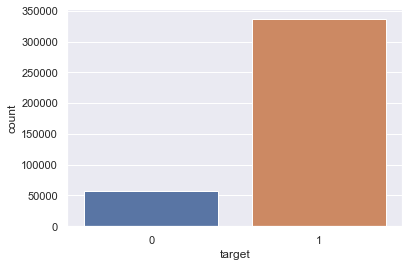

In [8]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="target", data=df_text)


Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [9]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])


In [10]:
df_text_balanced.reset_index(drop=True, inplace=True)
df_text_balanced

,Text,Score,target
0,"i received a sample of these candies, both the...",5,1
1,The title says it all - if you want a cracker ...,5,1
2,This Australian origination is truly a delight...,5,1
3,Yummy is all I can really say. My husband and ...,5,1
4,Love the strong taste it has. I will reach for...,5,1
...,...,...,...
114163,I just bought this soup today at my local groc...,1,0
114164,This soup is mostly broth. Although it has a k...,2,0
114165,"It is mostly broth, with the advertised 3/4 cu...",2,0
114166,I had ordered some of these a few months back ...,2,0


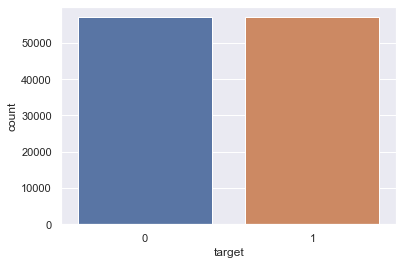

In [11]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="target", data=df_text_balanced)


### Text Pre-Processing

In [14]:
stopwords = set(stopwords.words('english'))
no_stop_words = set(word for word in stopwords 
                          if "n't" in word or 'no' in word)
stopwords = stopwords - no_stop_words
def remove_stop_words(data):
    stop_words =stopwords 
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data
def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")
def preprocssing(data):
    x=data
    x=remove_apostrophe(data)
    x=stemming(data)
    x=remove_punctuation(data)
    x=remove_stop_words(data)
    return x

In [15]:
%%time
df_text_balanced.Text = df_text_balanced.Text.apply(preprocssing) 


Wall time: 13min 5s


### Split Test & Training Data

In [16]:
X = df_text_balanced.Text
y =df_text_balanced.target 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)
X_train = tfidf_vectorizer.transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

### Modelling

##### Sklearn framework steps
 - init
 - fit
 - predict

In [19]:
 C = [0.001, 0.01, 0.1, 1, 10]
for i in C:
    log_model = LogisticRegression(C=i, max_iter=500, random_state=1)

    
    # training
    _ = log_model.fit(X_train, y_train)

    # predictions
    y_pred_train = log_model.predict(X_train)
    y_pred_test = log_model.predict(X_test)

    # evaluation
    print()
    print(log_model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_pred_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_pred_test)}")
    print('\n',70*'-')


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.8193250497391044
Test accuracy score : 0.819392134536218

 ----------------------------------------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.8348411476907291
Test accuracy score : 0.8345449767889989

 ----------------------------------------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.8634833639901398
Test accuracy score : 0.8580479402061254

 ----------------------------------------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.8890473866636636
Test accuracy score : 0.8701059823070859

 ----------------------------------------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.9066531526458701
Test accuracy score : 0.8670403783831129

 -------

In [21]:

print(f"Train accuracy score : {accuracy_score(y_train, y_pred_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_pred_test)}")

Train accuracy score : 0.9066531526458701
Test accuracy score : 0.8670403783831129


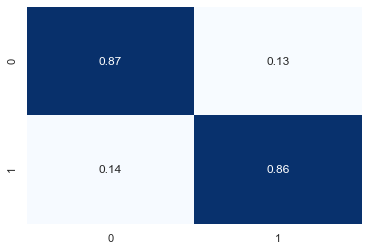

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix  
cm = confusion_matrix(y_test, y_preds_test, normalize='true')
    
sns.heatmap(
cm, annot=True, cmap='Blues', cbar=False, fmt='.2f')
plt.show()

### Raw Instance Prediction

In [34]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review=preprocssing(review)
    # Embed review using tf-idf vectorizer
    review =vectorizer.transform([review])

    # Predict using your model
    prediction = int(model.predict(review.reshape(1,-1)))
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [32]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [35]:
raw_test(review_2, log_model, tfidf_vectorizer)

'Negative'

### Saving Models for Deployment

In [36]:
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open("model.pkl", "wb") as f:
    pickle.dump(log_model, f)


### Load model Again and test them

In [40]:
loaded_model = pickle.load(open("model.pkl", 'rb'))
loaded_vect = pickle.load(open("transformer.pkl", 'rb'))

In [41]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

In [42]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

# Great Job !
### Now Deploy your ML model using Streamlit Framework